edwith의 부스트 코스 : "파이토치로 시작하는 딥러닝 기초" 를 바탕으로 작성되었습니다.  
https://www.boostcourse.org/ai214

# Batch Normalization

- Gradient Vanishing / Exploding
- Internal Covariate Shift
- Batch Normalization
- Full code : mnist_batchnorm

## Gradient Vanishing / Exploding

* Gradient Vanishing
기울기 소실, sigmoid function 을 사용할 때 발생했던 문제(relu 해결) gradient 가 너무 작아지면서 소멸하게 되는 문제 
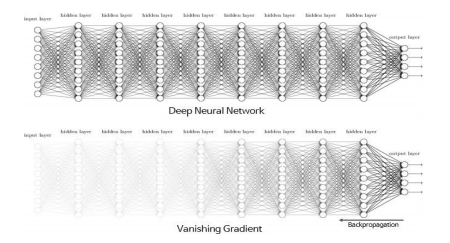

* Gradient Exploding
gradient 너무 커져 발생하는 문제, 중간에 미분계산 과정에서 너무 큰 값, nand 값이 나오는 경우를 말함.

### Solution (간접적인 방법)
* Change activation function (sigmoid ➡ relu)
* Careful initialization (weights 초기화)
* Small learning rate (Gradient Exploding 완화)

## Internal Covariate Shift
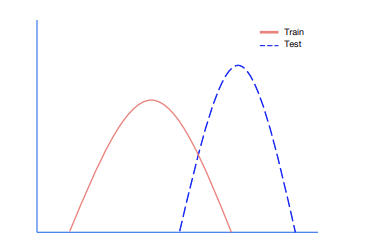

 Covariate Shift 란 train-set, test-set 의 분포의 차이를 말함. 이 차이가 문제를 만들어 냄.  
Batch Normalization 에서 주장하는 ICS 는 모델 전체에서의 input, output의 문제가 아니라, 각 layer마다 입출력에서, layer끼리의 Covariate Shift 가 발생한다고 말함. 때문에 layer의 깊이가 깊어질수록 distribution을 변경시키는 현상이 더 많이,크게 발생된다고 말함. 때문에 저자들은 이 ICS 를 해결하기 위해 Batch Normalization를 사용하였다고 함.  

## Batch Normalization
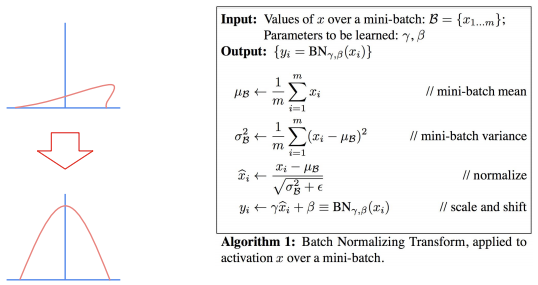
개념은 굉장히 간단함. ICS 현상을 해결하기 위해서 각 layer들마다 Normalization 을 하는 layer을 위치시켜 변형된 분포가 나오지 않도록 Normalization를 해주겠다는 개념임.  

neural network를 학습할 때, mini_batch 를 사용하게 되는데 이 mini_batch 마다 Normalization을 해주겠다는 의미에서 Batch_Normalization 라는 이름이 붙게 됨. 


## Full code : mnist_batchnorm

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)

cpu


In [3]:
learning_rate = 0.001
traing_epochs = 15
batch_size = 100
drop_prob = 0.5

In [4]:
mnist_train = dsets.MNIST(root='../MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=False)

mnist_test = dsets.MNIST(root='../MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=False)

In [5]:
data_loader = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

In [6]:
# nn layer
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 512, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

# xavier_uniform initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 512, bias=True)


bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3).to(device)

nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [7]:
# train
total_batch = len(data_loader)
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

for epoch in range(traing_epochs):
    bn_avg_cost = 0
    nn_avg_cost = 0
    
    bn_model.train()
    
    for X, Y in data_loader:
        x_train = X.view(-1, 28 * 28).to(device)
        y_train = Y.to(device)
        
        # bn_model train
        bn_prediction = bn_model(x_train)
        bn_cost = criterion(bn_prediction, y_train)
        bn_optimizer.zero_grad()
        bn_cost.backward()
        bn_optimizer.step()
        
        bn_avg_cost += bn_cost / total_batch
        # nn_model train
        nn_prediction = nn_model(x_train)
        nn_cost = criterion(nn_prediction, y_train)
        nn_optimizer.zero_grad()
        nn_cost.backward()
        nn_optimizer.step()
        
        nn_avg_cost += nn_cost / total_batch
    
    print('Epoch : {:4d}/{}, BN_Cost : {:.6f}, NN_Cost : {:.6f}'.format(epoch, traing_epochs, bn_avg_cost.item(), nn_avg_cost.item()))
    
print('Training finished')

Epoch :    0/15, BN_Cost : 1.206316, NN_Cost : 0.948875
Epoch :    1/15, BN_Cost : 0.196750, NN_Cost : 0.295372
Epoch :    2/15, BN_Cost : 0.143228, NN_Cost : 0.240833
Epoch :    3/15, BN_Cost : 0.114739, NN_Cost : 0.201998
Epoch :    4/15, BN_Cost : 0.098050, NN_Cost : 0.174786
Epoch :    5/15, BN_Cost : 0.086919, NN_Cost : 0.156808
Epoch :    6/15, BN_Cost : 0.079303, NN_Cost : 0.142556
Epoch :    7/15, BN_Cost : 0.072444, NN_Cost : 0.131019
Epoch :    8/15, BN_Cost : 0.068416, NN_Cost : 0.122854
Epoch :    9/15, BN_Cost : 0.061566, NN_Cost : 0.115048
Epoch :   10/15, BN_Cost : 0.057881, NN_Cost : 0.108034
Epoch :   11/15, BN_Cost : 0.055001, NN_Cost : 0.102573
Epoch :   12/15, BN_Cost : 0.051884, NN_Cost : 0.096396
Epoch :   13/15, BN_Cost : 0.049083, NN_Cost : 0.091615
Epoch :   14/15, BN_Cost : 0.047859, NN_Cost : 0.087302
Training finished
